<a href="https://colab.research.google.com/github/lej4545/AI_Project_Mask_Detection/blob/main/02_Projects/0827_LeeEunJin_VGG19_change_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras # 텐서플로우 임포트
keras.__version__ # 버전 확인

'2.6.0'

In [ ]:
from google.colab import drive # 구글 드라이브에서 구글 colab 연동

In [ ]:
drive.mount('/content/drive') # 구글 드라이브 마운트

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os # os모듈 임포트
for dirname, _, filenames in os.walk('/content/drive/My Drive/PART1_ai_project_20210824_0830/02_Projects'):
    for filename in filenames: # 아마도 위에 폴더 안에 있는 파일들을 불러와서 
        os.path.join(dirname, filename) # 폴더 이름과 파일 이름을 합쳐주는 것 같다.

In [ ]:
import pandas as pd # 필요한 모듈 임포트
import numpy as np
import seaborn as sns
from pandas import DataFrame

In [ ]:
traindir='/content/drive/My Drive/AI_project/01_Images/Train' # 학습할 데이터가 들어있는 폴더 경로
validdir='/content/drive/My Drive/AI_project/01_Images/Validation' #  검증하기 위한 데이터가 들어있는 폴더 경로
testdir='/content/drive/My Drive/AI_project/01_Images/Test' # 테스트 데이터가 들어있는 폴더 경로

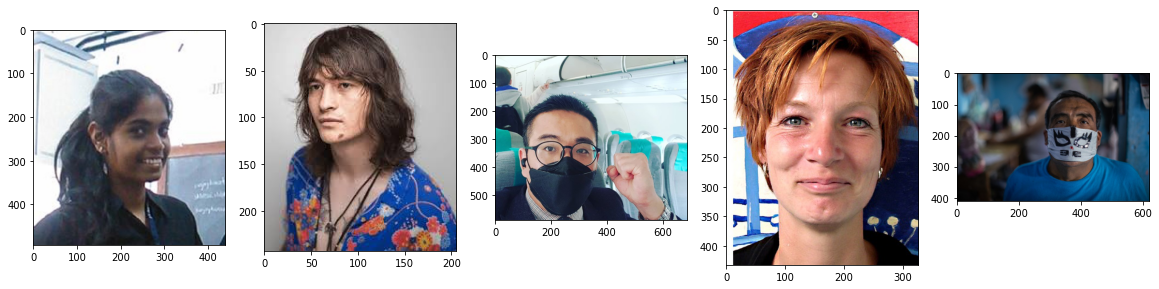

In [ ]:
path='/content/drive/My Drive/AI_project/01_Images/All'# 모든 이미지가 담겨있는 폴더
import cv2 
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,20)) # 잘 불러오는지 확인하기 위해 임의의 5장 사진 출력
for i in range(5):
    file=random.choice(os.listdir(path)) # 디렉토리에 있는 파일 리스트를 가져온다.
    img_path=os.path.join(path,file)
    image=mpimg.imread(img_path)
    ax=plt.subplot(1,5,i+1)
    plt.imshow(image)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img #imagedatagenerator 임포트
# # image augmentation 부분

# # train_data, test_data 전처리

# train_data=ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, shear_range=0.2)
# datagen = ImageDataGenerator(
#     rotation_range=40, # 40도 회전
#     width_shift_range=0.2, # 0.2만큼 옆으로 shift
#     height_shift_range=0.2, # 0.1만큼 위로 shift
#     shear_range=0.2, 
#     zoom_range=0.2, # 20% 확대
#     horizontal_flip=True, # 좌우 반전
#     fill_mode="nearest", # 회전하면서 생기는 빈 공간을 매꾸는 부분
# )

# img = load_img('/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/All/0.jpg')  # PIL 이미지
# x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
# x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150) 크기의 NumPy 배열

# # 지정된 폴더에 저장합니다. 어디에 지정할 지 아직 안정했으므로 일단 패쓰

# i = 0
# for batch in datagen.flow(x, batch_size=1,save_to_dir=path,save_prefix='people', save_format='jpeg'):
#     i += 1
#     if i > 10:
#         break  # 이미지 10장을 생성하고 마칩니다

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img #imagedatagenerator 임포트

# train_data, test_data 전처리
train_data=ImageDataGenerator(rescale=1.0/255, 
                              zoom_range=0.2, # 20% 확대
                              shear_range=0.2, # 이것은 회전에서 보이지 않는 일종의 '늘이기'를 이미지에 만듭니다
                               rotation_range=40,  # 40도 회전
                              width_shift_range=0.2, # 0.2만큼 옆으로 shift
                              height_shift_range=0.2, # 0.1만큼 위로 shift
                              horizontal_flip=True,) # 인풋을 무작위로 가로로 뒤집습니다.


# 이미지를 불러올 때 폴더명에 맞춰 자동으로 labelling 해준다.(2 classes => 'WithMask' : 0 ,'WithoutMask' : 1) 이미지 사이즈는 256 * 256, 배치 사이즈는 32
train_generator = train_data.flow_from_directory(directory=traindir,target_size=(256,256),class_mode='binary', batch_size=32, shuffle=True)
test_data=ImageDataGenerator(rescale=1.0/255) 
# valid generator 도 train generator와 마찬가지로 진행
valid_generator = test_data.flow_from_directory(directory=validdir,target_size=(256,256),class_mode='binary',batch_size=32)
# test 데이터도 train generator 에서 진행한 방식과 동일하고 추가적으로 rescaling을 진행
test_generator = test_data.flow_from_directory(directory=testdir,target_size=(256,256),class_mode='binary',batch_size=32,shuffle=False)

print(valid_generator.class_indices)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
{'WithMask': 0, 'WithoutMask': 1}


In [ ]:
from tensorflow.keras import layers, Sequential
from keras.applications.vgg19 import VGG19 # VGG19 모델 적용
from keras.applications.vgg19 import preprocess_input
import tensorflow as tf

# 사전 교육된 기본 모델 생성 
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))  

for layer in vgg19.layers:
    layer.trainable = False


vmodel = Sequential() # 모형 작성
vmodel.add(vgg19) # VGG19 기반 모델 추가
vmodel.add(layers.Flatten()) # 평평하게 만들어 Denser 레이어로 전환을 하기 위함.(fully connected되는 부분)
# Dense 첫번째 인자: 출력 뉴런의 수, 두번째 인자 activation 활성화 함수를 설정:
# 'relu' : rectifier 함수로 은닉층에 주로 쓰임. 'sigmoid' : 이진 분류 문제에서 출력 층에 주로 쓰임, 'softmax' : 다중 클래스 분류 문제에서 출력 층에 주로 쓰임.
vmodel.add(layers.Dense(1,activation='sigmoid')) # classcification 하기 위한 부분..

vmodel.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 32769     
Total params: 20,057,153
Trainable params: 32,769
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
vmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=['accuracy'])
# 데이터 학습. 
history = vmodel.fit(train_generator,steps_per_epoch=len(train_generator),epochs=20,validation_data=valid_generator, batch_size = 128)


Epoch 1/20
19/19 [==============================] - 20s 1s/step - loss: 33.7833 - accuracy: 0.9333 - val_loss: 19.5628 - val_accuracy: 0.9641
Epoch 2/20
19/19 [==============================] - 20s 1s/step - loss: 29.8910 - accuracy: 0.9433 - val_loss: 16.9631 - val_accuracy: 0.9608
Epoch 3/20
19/19 [==============================] - 20s 1s/step - loss: 25.5567 - accuracy: 0.9367 - val_loss: 27.6281 - val_accuracy: 0.9412
Epoch 4/20
19/19 [==============================] - 20s 1s/step - loss: 18.7785 - accuracy: 0.9467 - val_loss: 16.2519 - val_accuracy: 0.9575
Epoch 5/20
19/19 [==============================] - 20s 1s/step - loss: 22.4130 - accuracy: 0.9383 - val_loss: 20.5919 - val_accuracy: 0.9542
Epoch 6/20
19/19 [==============================] - 20s 1s/step - loss: 19.7822 - accuracy: 0.9517 - val_loss: 27.8225 - val_accuracy: 0.9412
Epoch 7/20
19/19 [==============================] - 20s 1s/step - loss: 14.3360 - accuracy: 0.9600 - val_loss: 17.4069 - val_accuracy: 0.9575
Epoch 

In [ ]:
# 학습된 모델 그래프로 plot하기
def plot_history(history,LR):
    LR = str(LR)
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss (LR = '+LR+')')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy (LR = '+LR+')')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


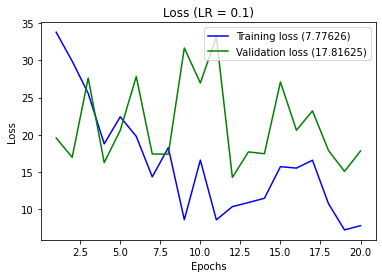

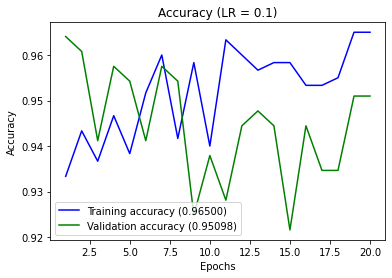

In [ ]:
plot_history(history,0.1)

In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))  

for layer in vgg19.layers:
    layer.trainable = False


vmodel_1 = Sequential() # 모형 작성
vmodel_1.add(vgg19) # VGG19 기반 모델 추가
vmodel_1.add(layers.Flatten()) # 평평하게 만들어 Denser 레이어로 전환을 하기 위함.(fully connected되는 부분)
# Dense 첫번째 인자: 출력 뉴런의 수, 두번째 인자 activation 활성화 함수를 설정:
# 'relu' : rectifier 함수로 은닉층에 주로 쓰임. 'sigmoid' : 이진 분류 문제에서 출력 층에 주로 쓰임, 'softmax' : 다중 클래스 분류 문제에서 출력 층에 주로 쓰임.
vmodel_1.add(layers.Dense(1,activation='sigmoid')) # classcification 하기 위한 부분..


In [ ]:
vmodel_1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
# 데이터 학습. 
history_1 = vmodel_1.fit(train_generator,steps_per_epoch=len(train_generator),epochs=20,validation_data=valid_generator, batch_size = 128)

Epoch 1/20
19/19 [==============================] - 21s 1s/step - loss: 6.9348 - accuracy: 0.5850 - val_loss: 6.3299 - val_accuracy: 0.5817
Epoch 2/20
19/19 [==============================] - 20s 1s/step - loss: 1.9383 - accuracy: 0.7917 - val_loss: 0.4265 - val_accuracy: 0.9412
Epoch 3/20
19/19 [==============================] - 20s 1s/step - loss: 0.8396 - accuracy: 0.8750 - val_loss: 0.2942 - val_accuracy: 0.9575
Epoch 4/20
19/19 [==============================] - 20s 1s/step - loss: 0.6095 - accuracy: 0.9017 - val_loss: 0.3858 - val_accuracy: 0.9085
Epoch 5/20
19/19 [==============================] - 20s 1s/step - loss: 0.3479 - accuracy: 0.9283 - val_loss: 0.2447 - val_accuracy: 0.9379
Epoch 6/20
19/19 [==============================] - 20s 1s/step - loss: 0.2132 - accuracy: 0.9400 - val_loss: 0.2500 - val_accuracy: 0.9379
Epoch 7/20
19/19 [==============================] - 20s 1s/step - loss: 0.3085 - accuracy: 0.9267 - val_loss: 0.7164 - val_accuracy: 0.8725
Epoch 8/20
19/19 [==

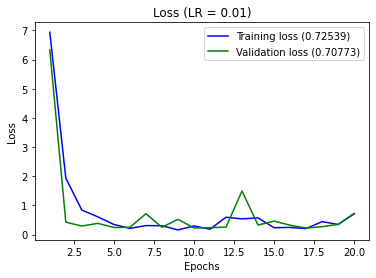

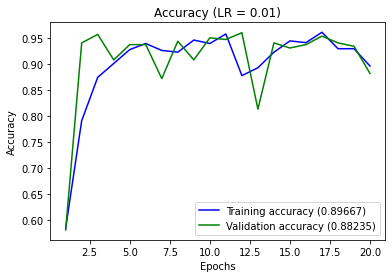

In [ ]:
plot_history(history_1,0.01)

In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))  

for layer in vgg19.layers:
    layer.trainable = False


vmodel_2 = Sequential() # 모형 작성
vmodel_2.add(vgg19) # VGG19 기반 모델 추가
vmodel_2.add(layers.Flatten()) # 평평하게 만들어 Denser 레이어로 전환을 하기 위함.(fully connected되는 부분)
# Dense 첫번째 인자: 출력 뉴런의 수, 두번째 인자 activation 활성화 함수를 설정:
# 'relu' : rectifier 함수로 은닉층에 주로 쓰임. 'sigmoid' : 이진 분류 문제에서 출력 층에 주로 쓰임, 'softmax' : 다중 클래스 분류 문제에서 출력 층에 주로 쓰임.
vmodel_2.add(layers.Dense(1,activation='sigmoid')) # classcification 하기 위한 부분..


In [ ]:
vmodel_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
# 데이터 학습. 
history_2 = vmodel_2.fit(train_generator,steps_per_epoch=len(train_generator),epochs=20,validation_data=valid_generator, batch_size = 128)

Epoch 1/20
19/19 [==============================] - 21s 1s/step - loss: 0.6356 - accuracy: 0.9000 - val_loss: 0.8399 - val_accuracy: 0.8987
Epoch 2/20
19/19 [==============================] - 20s 1s/step - loss: 0.6669 - accuracy: 0.8917 - val_loss: 0.5412 - val_accuracy: 0.9118
Epoch 3/20
19/19 [==============================] - 20s 1s/step - loss: 0.5027 - accuracy: 0.9083 - val_loss: 0.5544 - val_accuracy: 0.9020
Epoch 4/20
19/19 [==============================] - 20s 1s/step - loss: 0.5461 - accuracy: 0.9000 - val_loss: 0.6489 - val_accuracy: 0.8922
Epoch 5/20
19/19 [==============================] - 20s 1s/step - loss: 0.4205 - accuracy: 0.9083 - val_loss: 0.3418 - val_accuracy: 0.9248
Epoch 6/20
19/19 [==============================] - 20s 1s/step - loss: 0.2874 - accuracy: 0.9383 - val_loss: 0.2470 - val_accuracy: 0.9641
Epoch 7/20
19/19 [==============================] - 20s 1s/step - loss: 0.3272 - accuracy: 0.9217 - val_loss: 0.2334 - val_accuracy: 0.9510
Epoch 8/20
19/19 [==

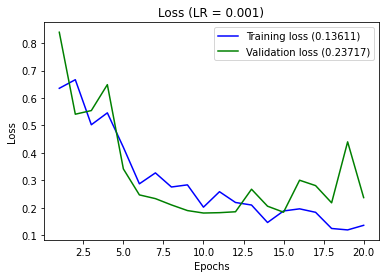

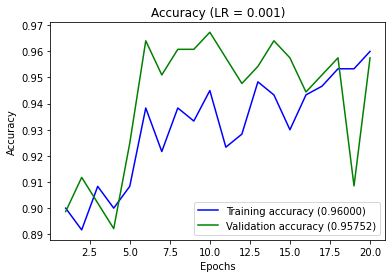

In [ ]:
plot_history(history_2,0.001)

In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))  

for layer in vgg19.layers:
    layer.trainable = False


vmodel_3 = Sequential() # 모형 작성
vmodel_3.add(vgg19) # VGG19 기반 모델 추가
vmodel_3.add(layers.Flatten()) # 평평하게 만들어 Denser 레이어로 전환을 하기 위함.(fully connected되는 부분)
# Dense 첫번째 인자: 출력 뉴런의 수, 두번째 인자 activation 활성화 함수를 설정:
# 'relu' : rectifier 함수로 은닉층에 주로 쓰임. 'sigmoid' : 이진 분류 문제에서 출력 층에 주로 쓰임, 'softmax' : 다중 클래스 분류 문제에서 출력 층에 주로 쓰임.
vmodel_3.add(layers.Dense(1,activation='sigmoid')) # classcification 하기 위한 부분..


In [ ]:
vmodel_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
# 데이터 학습. 
history_3 = vmodel_3.fit(train_generator,steps_per_epoch=len(train_generator),epochs=20,validation_data=valid_generator, batch_size = 128)

Epoch 1/20
19/19 [==============================] - 21s 1s/step - loss: 0.0802 - accuracy: 0.9717 - val_loss: 0.1252 - val_accuracy: 0.9673
Epoch 2/20
19/19 [==============================] - 20s 1s/step - loss: 0.0849 - accuracy: 0.9650 - val_loss: 0.1149 - val_accuracy: 0.9673
Epoch 3/20
19/19 [==============================] - 20s 1s/step - loss: 0.0750 - accuracy: 0.9750 - val_loss: 0.1094 - val_accuracy: 0.9542
Epoch 4/20
19/19 [==============================] - 20s 1s/step - loss: 0.0790 - accuracy: 0.9750 - val_loss: 0.1349 - val_accuracy: 0.9608
Epoch 5/20
19/19 [==============================] - 20s 1s/step - loss: 0.0714 - accuracy: 0.9800 - val_loss: 0.1268 - val_accuracy: 0.9608
Epoch 6/20
19/19 [==============================] - 20s 1s/step - loss: 0.0948 - accuracy: 0.9617 - val_loss: 0.1254 - val_accuracy: 0.9641
Epoch 7/20
19/19 [==============================] - 20s 1s/step - loss: 0.0861 - accuracy: 0.9683 - val_loss: 0.1130 - val_accuracy: 0.9673
Epoch 8/20
19/19 [==

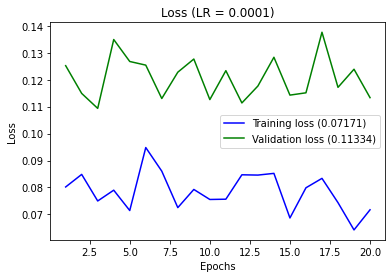

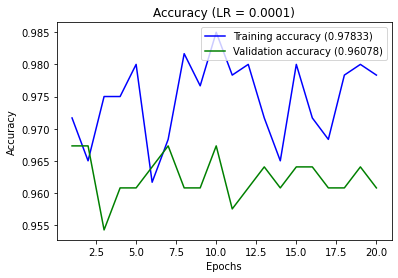

In [ ]:
plot_history(history_3,0.0001)

In [ ]:
# LR = 0.1 에 대한 TEST 값
predictons = vmodel.predict(test_generator)
predictions = np.round(predictons)

m = tf.keras.metrics.BinaryAccuracy()
y = np.hstack((np.zeros(50),np.ones(50)))
m.update_state(y, predictions)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.92>

In [ ]:
# LR = 0.01 에 대한 TEST 값
predictons = vmodel_1.predict(test_generator)
predictions = np.round(predictons)

m = tf.keras.metrics.BinaryAccuracy()
y = np.hstack((np.zeros(50),np.ones(50)))
m.update_state(y, predictions)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.88>

In [ ]:
# LR = 0.0001 에 대한 TEST 값
predictons = vmodel_2.predict(test_generator)
predictions = np.round(predictons)

m = tf.keras.metrics.BinaryAccuracy()
y = np.hstack((np.zeros(50),np.ones(50)))
m.update_state(y, predictions)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.93>

In [ ]:
# LR = 0.000001 에 대한 TEST 값
predictons = vmodel_3.predict(test_generator)
predictions = np.round(predictons)

m = tf.keras.metrics.BinaryAccuracy()
y = np.hstack((np.zeros(50),np.ones(50)))
m.update_state(y, predictions)
m.result()
# LR=0.

<tf.Tensor: shape=(), dtype=float32, numpy=0.95>